In [1]:
import sys
sys.path.append("../../")
from mfmodeling import SingleGP
from time import time as timer
import pickle

# Uncomment below to use GPy implementation.
# Note that only RBF kernel is supported in the GPy implementation now.
"""
from mfmodeling.SingleGP_GPy import SingleGP
"""

help(SingleGP)

2024-10-25 11:32:12.599133: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-25 11:32:12.685698: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-25 11:32:12.689140: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/smaeyama/mylib/netcdf-fortran-4.6.1-ifx/lib:/opt/intel/oneapi/tbb/2021.12/env/../lib/intel64/gcc4.8:/

Help on class SingleGP in module mfmodeling.SingleGP_GPflow:

class SingleGP(builtins.object)
 |  SingleGP(*args, **kwargs)
 |  
 |  Gaussian process regression.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, *args, **kwargs)
 |      Parameters
 |      ----------
 |      data : list[2]
 |          List of training data of y=f(x), where data input x and output y are vectors.
 |          [data_input[nsample,ninput], data_output[nsample,noutput]]
 |      kernel : Str
 |          Name of kernel to use.
 |      kernel_args : Dict
 |          Optional arguments for the kernel.
 |      noise_level : Float
 |          Optional initial value for the noise level.
 |      normalize : Bool
 |          Options for normalizing input data.
 |      augmented_dim : Int
 |          Augmented dimension used for create the NARGP kernel.
 |          It this parameter is set, NARGP kernel is created.
 |  
 |  optimize(self, optimize_restarts=30, max_iters=400, optimizer_name='Scipy', optimizer_param

### Preparation of data set
https://scikit-learn.org/stable/auto_examples/gaussian_process/plot_gpr_co2.html

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
import pandas as pd
import tensorflow as tf

np.random.seed(11)
tf.random.set_seed(11)

co2 = fetch_openml(data_id=41187, as_frame=True)
co2.frame.head()
co2_data = co2.frame
co2_data["date"] = pd.to_datetime(co2_data[["year", "month", "day"]])
co2_data = co2_data[["date", "co2"]].set_index("date")
co2_data.head()
try:
    co2_data_resampled_monthly = co2_data.resample("ME")
except ValueError:
    # pandas < 2.2 uses M instead of ME
    co2_data_resampled_monthly = co2_data.resample("M")
co2_data = co2_data_resampled_monthly.mean().dropna(axis="index", how="any")
x = (co2_data.index.year + co2_data.index.month / 12).to_numpy().reshape(-1, 1)
y = co2_data["co2"].to_numpy()[:,np.newaxis]

(521, 1) (521, 1)


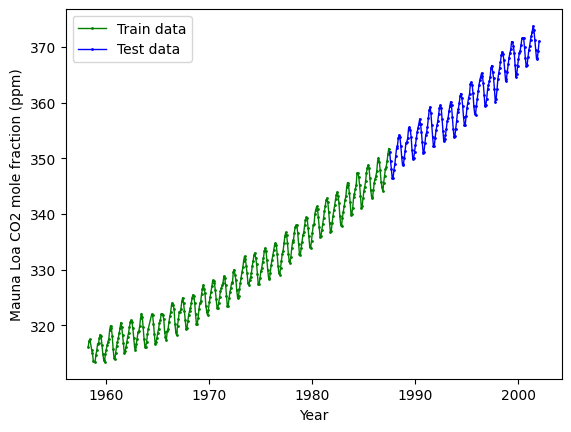

In [3]:
data_all = [x,y]
print(x.shape, y.shape)
nsplit = data_all[0].shape[0]//3*2
data_train = [x[:nsplit],y[:nsplit]]
data_test = [x[nsplit:],y[nsplit:]]
# x=np.arange(x[0],x[0]+4*(x[-1]-x[0]),x[1]-x[0])
# x=x.reshape(len(x),1)
# print(x.shape)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(data_train[0], data_train[1], 'g.-', label='Train data', linewidth = 1, markersize=2)
ax.plot(data_test[0], data_test[1], 'b.-', label='Test data', linewidth = 1, markersize=2)
ax.set_xlabel("Year")
ax.set_ylabel("Mauna Loa CO2 mole fraction (ppm)")
ax.legend()
plt.show()

### Gaussian process regression

#### RBF kernel

In [4]:
# t1=timer()
# # Create Single GP instance with training data set
# model_singleGP = SingleGP(data = data_train)

# # Optimize hyper parameters
# model_singleGP.optimize(optimize_restarts=10, verbose=True)
# t2=timer();print("Elapsed time [sec]=",t2-t1)

# with open("model_singleGP_RBF.pkl","wb") as f:
#     pickle.dump(model_singleGP,f)

with open("model_singleGP_RBF.pkl","rb") as f:
    model_singleGP = pickle.load(f)

2024-10-25 11:32:16.209632: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/smaeyama/mylib/netcdf-fortran-4.6.1-ifx/lib:/opt/intel/oneapi/tbb/2021.12/env/../lib/intel64/gcc4.8:/opt/intel/oneapi/mpi/2021.12/opt/mpi/libfabric/lib:/opt/intel/oneapi/mpi/2021.12/lib:/opt/intel/oneapi/mkl/2024.1/lib:/opt/intel/oneapi/ippcp/2021.11/lib/:/opt/intel/oneapi/ipp/2021.11/lib:/opt/intel/oneapi/dpl/2022.5/lib:/opt/intel/oneapi/dnnl/2024.1/lib:/opt/intel/oneapi/debugger/2024.1/opt/debugger/lib:/opt/intel/oneapi/dal/2024.2/lib:/opt/intel/oneapi/compiler/2024.1/opt/oclfpga/host/linux64/lib:/opt/intel/oneapi/compiler/2024.1/opt/compiler/lib:/opt/intel/oneapi/compiler/2024.1/lib:/opt/intel/oneapi/ccl/2021.12/lib/
2024-10-25 11:32:16.209676: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
202

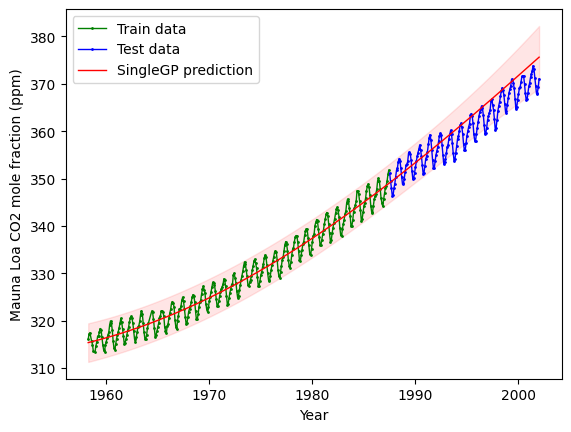

In [5]:
# Prediction
mean, var = model_singleGP.predict(x)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(data_train[0], data_train[1], 'g.-', label='Train data', linewidth = 1, markersize=2)
ax.plot(data_test[0], data_test[1], 'b.-', label='Test data', linewidth = 1, markersize=2)
ax.plot(x[:,0], mean[:,0], 'r', label = 'SingleGP prediction', linewidth = 1)
ax.fill_between(x[:,0], (mean[:,0]-2.0*np.sqrt(var[:,0])).ravel(), (mean[:,0]+2.0*np.sqrt(var[:,0])).ravel(), alpha=0.1, color='red')
ax.set_xlabel("Year")
ax.set_ylabel("Mauna Loa CO2 mole fraction (ppm)")
ax.legend()
plt.show()

### The following are the predictions of Spectral Mixture Kernel and Neural Kernel Network. 
### GPy version of SingleGP will use RBF kernel because these kernels are not yet implemented it.

#### Spectral Mixture Kernel

In [6]:
# t1=timer()
# # Create Single GP instance with training data set
# model_singleGP = SingleGP(
#     data = data_train,
#     kernel = "SpectralMixture",
#     kernel_args = {"n_components": 20}  # Spectral Mixture Kernel with 20 components.
#     )

# # Optimize hyper parameters
# model_singleGP.optimize(optimize_restarts=10, verbose=True)
# t2=timer();print("Elapsed time [sec]=",t2-t1)

with open("model_singleGP_SMK.pkl","rb") as f:
    model_singleGP = pickle.load(f)

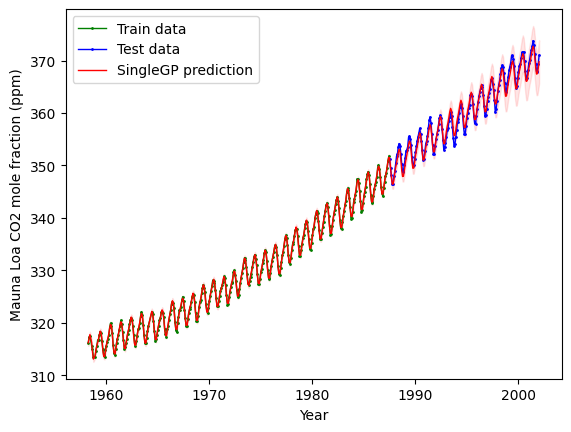

In [7]:
# Prediction
mean, var = model_singleGP.predict(x)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(data_train[0], data_train[1], 'g.-', label='Train data', linewidth = 1, markersize=2)
ax.plot(data_test[0], data_test[1], 'b.-', label='Test data', linewidth = 1, markersize=2)
ax.plot(x[:,0], mean[:,0], 'r', label = 'SingleGP prediction', linewidth = 1)
ax.fill_between(x[:,0], (mean[:,0]-2.0*np.sqrt(var[:,0])).ravel(), (mean[:,0]+2.0*np.sqrt(var[:,0])).ravel(), alpha=0.1, color='red')
ax.set_xlabel("Year")
ax.set_ylabel("Mauna Loa CO2 mole fraction (ppm)")
ax.legend()
plt.show()

#### Neural Kernel Network

In [8]:
t1=timer()

import gpflow
# # Define primitive kernels and neural network
# primitive_kernels = [
#     {'name': 'Linear'},
#     # periodic kernel requires base kernel setting.
#     {'name': 'Periodic', 'params': {'base_kernel': gpflow.kernels.SquaredExponential()}},
#     {'name': 'ExpQuad'},
#     {'name': 'RatQuad'},
#     {'name': 'Linear'},
#     {'name': 'RatQuad'},
#     {'name': 'ExpQuad'},
#     # periodic kernel requires base kernel setting.
#     {'name': 'Periodic', 'params': {'base_kernel': gpflow.kernels.SquaredExponential()}}]
# neural_network = [
#         {'name': 'Linear',  'params': {'input_dim': 8, 'output_dim': 8}},
#         {'name': 'Product', 'params': {'input_dim': 8, 'step': 2}},
#         {'name': 'Linear',  'params': {'input_dim': 4, 'output_dim': 4}},
#         {'name': 'Product', 'params': {'input_dim': 4, 'step': 2}},
#         {'name': 'Linear',  'params': {'input_dim': 2, 'output_dim': 1}}]


# # Create Single GP instance with training data set
# model_singleGP = SingleGP(
#     data = data_train,
#     kernel = "NeuralKernelNetwork",
#     # Pass the primitive kernels and neural network via "kernel_args" key
#     kernel_args = {"neural_network": neural_network,
#                    "primitive_kernels": primitive_kernels},
#     normalize=True  # Normalize data for stability
#     )

# # Optimize hyperparameters with Adam
# model_singleGP.optimize(
#     verbose=False,
#     optimizer_name="Adam",
#     max_iters=2000,
#     optimizer_parameters={"learning_rate": 0.01},
#     optimize_restarts=5,
#     # Use built-in random initialization of the NeuralKernelNetwork class
#     use_built_in_initialization=True,
#     plot_history=False)

# t2=timer();print("Elapsed time [sec]=",t2-t1)

with open("model_singleGP_NKN.pkl","rb") as f:
    model_singleGP = pickle.load(f)

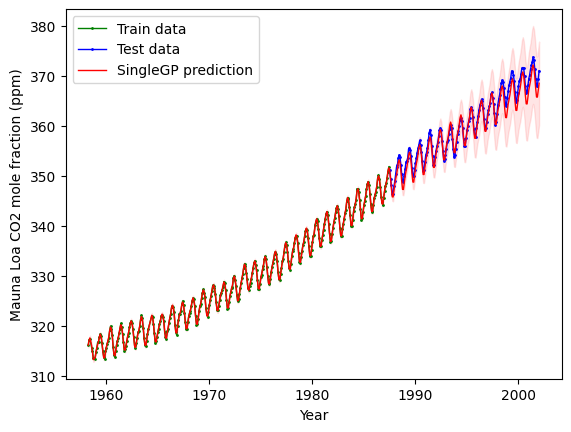

In [9]:
# Prediction
mean, var = model_singleGP.predict(x)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(data_train[0], data_train[1], 'g.-', label='Train data', linewidth = 1, markersize=2)
ax.plot(data_test[0], data_test[1], 'b.-', label='Test data', linewidth = 1, markersize=2)
ax.plot(x[:,0], mean[:,0], 'r', label = 'SingleGP prediction', linewidth = 1)
ax.fill_between(x[:,0], (mean[:,0]-2.0*np.sqrt(var[:,0])).ravel(), (mean[:,0]+2.0*np.sqrt(var[:,0])).ravel(), alpha=0.1, color='red')
ax.set_xlabel("Year")
ax.set_ylabel("Mauna Loa CO2 mole fraction (ppm)")
ax.legend()
plt.show()